In [0]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import glob
import re
import io
import requests
import csv

from math import radians, sin, cos, acos, log, pi, tan, asin,sqrt
from decimal import Decimal
from bokeh.plotting import figure, show, output_notebook
from bokeh.tile_providers import CARTODBPOSITRON
from ast import literal_eval
from scipy import stats

In [2]:
from google.colab import drive
drive.mount('drive')

Drive already mounted at drive; to attempt to forcibly remount, call drive.mount("drive", force_remount=True).


## Importing AirBnb data

### Listings

In [0]:
#Import listings data from each scraping iteration (from oldest to newest)
url_l1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_4_15.csv'
url_l2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_5_18.csv'
url_l3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_7_18.csv'
url_l4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_9_14.csv'
url_l5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_10_11.csv'
url_l6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_11_15.csv'
url_l7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_18_12_13.csv'
url_l8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_1_17.csv'
url_l9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_2_9.csv'
url_l10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_3_12.csv'
url_l11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_4_15.csv'
url_l12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_5_19.csv'
url_l13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_6_14.csv'
url_l14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/listings/listings_19_7_15.csv'


listings_1 = pd.read_csv(url_l1)
listings_2 = pd.read_csv(url_l2)
listings_3 = pd.read_csv(url_l3)
listings_4 = pd.read_csv(url_l4)
listings_5 = pd.read_csv(url_l5)
listings_6 = pd.read_csv(url_l6)
listings_7 = pd.read_csv(url_l7)
listings_8 = pd.read_csv(url_l8)
listings_9 = pd.read_csv(url_l9)
listings_10 = pd.read_csv(url_l10)
listings_11 = pd.read_csv(url_l11)
listings_12 = pd.read_csv(url_l12)
listings_13 = pd.read_csv(url_l13)
listings_14 = pd.read_csv(url_l14)

In [0]:
#The most recent listing data is the one we want, but some past listings may no longer show up
#We'll append to the most recent listings data from past scrapings, but we'll only keep the most recent information for each id 
listings=listings_14
listings=listings.append(listings_13)
listings=listings.append(listings_12)
listings=listings.append(listings_11)
listings=listings.append(listings_10)
listings=listings.append(listings_9)
listings=listings.append(listings_8)
listings=listings.append(listings_7)
listings=listings.append(listings_6)
listings=listings.append(listings_5)
listings=listings.append(listings_4)
listings=listings.append(listings_3)
listings=listings.append(listings_2)
listings=listings.append(listings_1)

listings=listings.drop_duplicates(subset="id", keep='first')
listings=listings.drop(columns=['name','host_name','price','minimum_nights','neighbourhood_group'])
listings=listings.rename(index=str, columns={"id": "listing_id"})

listings=listings.dropna(subset=['last_review'], axis=0)
listings['lr_m']=listings.last_review.apply(lambda x: int(x[5:7]))
listings['lr_d']=listings.last_review.apply(lambda x: int(x[8:10]))
listings['lr_y']=listings.last_review.apply(lambda x: int(x[0:4]))
listings.last_review = pd.to_datetime(listings.last_review)
listings['lat']=listings.latitude.round(2)
listings['lon']=listings.longitude.round(2)
listings['location'] = list(zip(listings.latitude, listings.longitude))
listings['loc'] = list(zip(listings.lat, listings.lon))

listings = listings.assign(loc_id=(listings['loc'].astype('category').cat.codes))

listings.room_type = listings.room_type.apply(lambda x: 1 if x=="Entire home/apt" else 2 if x=="Private room" else 3)

listings=listings[listings.number_of_reviews > 9]
listings=listings[listings.lr_y > 2017]
listings=listings[listings.availability_365>9]
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m<4)].index)
listings=listings.drop(listings[(listings.lr_y==2018) & (listings.lr_m==4) & (listings.lr_d<15)].index)

In [5]:
listings_locations = listings[['loc','loc_id']]
listings_locations = listings_locations.drop_duplicates('loc_id')
listings_locations = listings_locations.set_index('loc_id')
listings_locations = listings_locations.sort_index()
listings_locations = listings_locations.reset_index()
listings_locations['loc_id2']=listings_locations.index
list_locs=list(listings_locations['loc'])
len(list_locs)

370

In [6]:
listings=listings.merge(listings_locations,on=['loc_id','loc'])
listings.head(10)

,listing_id,host_id,neighbourhood,latitude,longitude,room_type,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,loc_id2
0,2384,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
1,2604454,13339125,Hyde Park,41.78977,-87.58916,1,85,2019-07-11,1.42,3,41,7,11,2019,41.79,-87.59,"(41.789770000000004, -87.58915999999999)","(41.79, -87.59)",124,71
2,6524346,34121377,Hyde Park,41.79119,-87.59099,2,26,2019-07-07,0.52,1,34,7,7,2019,41.79,-87.59,"(41.79119, -87.59099)","(41.79, -87.59)",124,71
3,18549719,47172572,Hyde Park,41.79296,-87.59275,1,127,2019-07-02,4.77,60,96,7,2,2019,41.79,-87.59,"(41.79296, -87.59275)","(41.79, -87.59)",124,71
4,22320506,47172572,Hyde Park,41.79386,-87.59469,1,99,2019-07-08,5.32,60,93,7,8,2019,41.79,-87.59,"(41.793859999999995, -87.59469)","(41.79, -87.59)",124,71
5,27525969,47172572,Hyde Park,41.79363,-87.59155,1,56,2019-07-11,5.30,60,18,7,11,2019,41.79,-87.59,"(41.79363, -87.59155)","(41.79, -87.59)",124,71
6,22970180,47172572,Hyde Park,41.79489,-87.59412,1,56,2019-03-09,4.34,61,15,3,9,2019,41.79,-87.59,"(41.79489, -87.59411999999999)","(41.79, -87.59)",124,71
7,4505,5775,South Lawndale,41.85495,-87.69696,1,373,2019-06-25,2.96,1,326,6,25,2019,41.85,-87.70,"(41.85495, -87.69696)","(41.85, -87.7)",190,127
8,5785758,250400,South Lawndale,41.85290,-87.69617,2,15,2018-12-10,0.33,7,240,12,10,2018,41.85,-87.70,"(41.8529, -87.69617)","(41.85, -87.7)",190,127
9,5807478,250400,South Lawndale,41.85439,-87.69620,2,10,2019-06-27,0.28,7,325,6,27,2019,41.85,-87.70,"(41.85439, -87.6962)","(41.85, -87.7)",190,127


### Reviews

In [0]:
#Import review data
url_r = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/reviews/reviews_15_7_19.csv'
reviews = pd.read_csv(url_r)

In [0]:
reviews['month']=reviews.date.apply(lambda x: int(x[5:7]))
reviews['day']=reviews.date.apply(lambda x: int(x[8:10]))
reviews['year']=reviews.date.apply(lambda x: int(x[0:4]))
reviews.date = pd.to_datetime(reviews.date)

reviews=reviews[reviews.year > 2017]
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month<4)].index)
reviews=reviews.drop(reviews[(reviews.year==2018) & (reviews.month==4) & (reviews.day<15)].index)
reviews=reviews.drop(columns=['month','day','year'])
reviews['review']=1

In [9]:
reviews.head(10)

,listing_id,date,review
112,2384,2018-04-15,1
113,2384,2018-04-22,1
114,2384,2018-04-25,1
115,2384,2018-05-05,1
116,2384,2018-05-14,1
117,2384,2018-05-18,1
118,2384,2018-05-20,1
119,2384,2018-05-27,1
120,2384,2018-05-31,1
121,2384,2018-06-05,1


### Calendar

In [0]:
#Import calendar data from each scraping iteration (from oldest to newest)
url_c1 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_4_15.zip'
url_c2 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_5_18.zip'
url_c3 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_7_18.zip'
url_c4 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_9_14.zip'
url_c5 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_10_11.zip'
url_c6 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_11_15.zip'
url_c7 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_18_12_13.zip'
url_c8 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_1_17.zip'
url_c9 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_2_9.zip'
url_c10 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_3_12.zip'
url_c11 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_4_15.zip'
url_c12 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_5_19.zip'
url_c13 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_6_14.zip'
url_c14 = 'https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/calendar/calendar_19_7_15.zip'


calendar_1 = pd.read_csv(url_c1)
calendar_2 = pd.read_csv(url_c2)
calendar_3 = pd.read_csv(url_c3)
calendar_4 = pd.read_csv(url_c4)
calendar_5 = pd.read_csv(url_c5)
calendar_6 = pd.read_csv(url_c6)
calendar_7 = pd.read_csv(url_c7)
calendar_8 = pd.read_csv(url_c8)
calendar_9 = pd.read_csv(url_c9)
calendar_10 = pd.read_csv(url_c10)
calendar_11 = pd.read_csv(url_c11)
calendar_12 = pd.read_csv(url_c12)
calendar_13 = pd.read_csv(url_c13)
calendar_14 = pd.read_csv(url_c14)

In [0]:
#For each calendar scraping, add scraping date
calendar_1['scr_date']='2018-04-15'
calendar_2['scr_date']='2018-05-18'
calendar_3['scr_date']='2018-07-18'
calendar_4['scr_date']='2018-09-14'
calendar_5['scr_date']='2018-10-11'
calendar_6['scr_date']='2018-11-15'
calendar_7['scr_date']='2018-12-13'
calendar_8['scr_date']='2019-01-17'
calendar_9['scr_date']='2019-02-09'
calendar_10['scr_date']='2019-03-12'
calendar_11['scr_date']='2019-04-15'
calendar_12['scr_date']='2019-05-19'
calendar_13['scr_date']='2019-06-14'
calendar_14['scr_date']='2019-07-15'

In [12]:
calendar=calendar_14
calendar=calendar.append(calendar_13)
calendar=calendar.append(calendar_12)
calendar=calendar.append(calendar_11)
calendar=calendar.append(calendar_10)
calendar=calendar.append(calendar_9)
calendar=calendar.append(calendar_8)
calendar=calendar.append(calendar_7)
calendar=calendar.append(calendar_6)
calendar=calendar.append(calendar_5)
calendar=calendar.append(calendar_4)
calendar=calendar.append(calendar_3)
calendar=calendar.append(calendar_2)
calendar=calendar.append(calendar_1)

calendar=calendar[['listing_id','date','price','scr_date']]
calendar=calendar.drop_duplicates(subset=['listing_id','date','price'])
calendar=calendar.dropna(axis=0,subset=['price'])
calendar['month']=calendar.date.apply(lambda x: int(x[5:7]))
calendar['day']=calendar.date.apply(lambda x: int(x[8:10]))
calendar['year']=calendar.date.apply(lambda x: int(x[0:4]))
calendar.date = pd.to_datetime(calendar.date)
calendar.scr_date = pd.to_datetime(calendar.scr_date)
calendar.price = calendar.price.apply(lambda x: float(re.sub("[^\d\.]", "", (x[1:-3]))))
calendar.price = pd.to_numeric(calendar.price)
calendar['time_since_scr']=calendar.date - calendar.scr_date

calendar=calendar.merge(reviews,on=['listing_id','date'],how='left')
calendar['review']=calendar['review'].fillna(0)
calendar['review']=calendar['review'].astype(int)

cal_change = calendar[calendar.duplicated(['listing_id','date'],keep=False)]
cal_change=cal_change.sort_values(by=['listing_id','date'])
calendar=calendar.drop_duplicates(subset=['listing_id','date'])
calendar=calendar.sort_values(by=['listing_id','date'])

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [13]:
calendar.head(10)

,listing_id,date,price,scr_date,month,day,year,time_since_scr,review
14493724,2384,2018-04-15,55.0,2018-04-15,4,15,2018,0 days,1
14493723,2384,2018-04-16,55.0,2018-04-15,4,16,2018,1 days,0
14493722,2384,2018-04-17,55.0,2018-04-15,4,17,2018,2 days,0
14493721,2384,2018-04-18,55.0,2018-04-15,4,18,2018,3 days,0
14493720,2384,2018-04-22,55.0,2018-04-15,4,22,2018,7 days,1
14493719,2384,2018-04-23,55.0,2018-04-15,4,23,2018,8 days,0
14493718,2384,2018-04-24,55.0,2018-04-15,4,24,2018,9 days,0
14493717,2384,2018-04-28,55.0,2018-04-15,4,28,2018,13 days,0
14493716,2384,2018-04-29,55.0,2018-04-15,4,29,2018,14 days,0
14493715,2384,2018-04-30,55.0,2018-04-15,4,30,2018,15 days,0


In [14]:
cal_change.head(10)

,listing_id,date,price,scr_date,month,day,year,time_since_scr,review
13873240,2384,2018-06-11,65.0,2018-05-18,6,11,2018,24 days,0
14493696,2384,2018-06-11,80.0,2018-04-15,6,11,2018,57 days,0
13873226,2384,2018-07-01,65.0,2018-05-18,7,1,2018,44 days,1
14493689,2384,2018-07-01,60.0,2018-04-15,7,1,2018,77 days,1
13873225,2384,2018-07-02,65.0,2018-05-18,7,2,2018,45 days,0
14493688,2384,2018-07-02,60.0,2018-04-15,7,2,2018,78 days,0
13203073,2384,2018-07-26,75.0,2018-07-18,7,26,2018,8 days,1
13873224,2384,2018-07-26,65.0,2018-05-18,7,26,2018,69 days,1
14493666,2384,2018-07-26,60.0,2018-04-15,7,26,2018,102 days,1
13873223,2384,2018-07-27,65.0,2018-05-18,7,27,2018,70 days,0


## Importing crimes data

In [74]:
url_cr = "https://raw.githubusercontent.com/araujoghm/DataScienceEMAp_AraujoNovais/master/dados/crimes/crimes.csv"
crimes = pd.read_csv(url_cr)
crimes = crimes[['DATE  OF OCCURRENCE','LATITUDE','LONGITUDE','ARREST',' PRIMARY DESCRIPTION']]
crimes = crimes.rename(index=str, columns={"DATE  OF OCCURRENCE": "date","LONGITUDE": "longitude","LATITUDE": "latitude"," PRIMARY DESCRIPTION": "desc", "ARREST": "arrest"})
crimes = crimes[crimes.desc!="CONCEALED CARRY LICENSE VIOLATION"]
crimes = crimes[crimes.desc!="DECEPTIVE PRACTICE"]
crimes = crimes[crimes.desc!="INTERFERENCE WITH PUBLIC OFFICER"]
crimes = crimes[crimes.desc!="OBSCENITY"]
crimes = crimes[crimes.desc!="NON-CRIMINAL"]
crimes = crimes[crimes.desc!="NON-CRIMINAL (SUBJECT SPECIFIED)"]
crimes = crimes[crimes.desc!="LIQUOR LAW VIOLATION"]
crimes = crimes[crimes.desc!="PUBLIC INDECENCY"]

crimes['lat']=crimes.latitude.round(2)
crimes['lon']=crimes.longitude.round(2)
crimes['location'] = list(zip(crimes.latitude, crimes.longitude))
crimes['loc'] = list(zip(crimes.lat, crimes.lon))
crimes = crimes.assign(loc_id=(crimes['loc'].astype('category').cat.codes))
crimes.arrest = crimes.arrest.apply(lambda x: 0 if x=="N" else 1)
crimes.date = crimes.date.apply(lambda x: x[0:10])
crimes.date = pd.to_datetime(crimes.date)
crimes['date_str'] = crimes.date.astype('str')
crimes['month']=crimes.date_str.apply(lambda x: int(x[5:7]))
crimes['day']=crimes.date_str.apply(lambda x: int(x[8:10]))
crimes['year']=crimes.date_str.apply(lambda x: int(x[0:4]))
crimes=crimes.drop(columns=['date_str','desc','latitude','longitude','location'])
#Dropping incomplete observations
crimes=crimes.drop(crimes[(crimes.year==2019) & (crimes.month==7)].index)

crimes=crimes.dropna(axis=0)
crimes=crimes.sort_values(by='date')
crimes.head()

,date,arrest,lat,lon,loc,loc_id,month,day,year
0,2018-07-09,1,41.89,-87.63,"(41.89, -87.63)",0,7,9,2018
462,2018-07-09,0,41.91,-87.77,"(41.91, -87.77)",6280,7,9,2018
463,2018-07-09,0,41.76,-87.68,"(41.76, -87.68)",6039,7,9,2018
464,2018-07-09,1,41.79,-87.65,"(41.79, -87.65)",6105,7,9,2018
465,2018-07-09,1,41.90,-87.64,"(41.9, -87.64)",6274,7,9,2018


In [75]:
crimes_locations = crimes[['loc','loc_id']]
crimes_locations = crimes_locations.drop_duplicates('loc_id')
crimes_locations = crimes_locations.set_index('loc_id')
crimes_locations = crimes_locations.sort_index()
crimes_locations = crimes_locations.reset_index()
crimes_locations['crim_loc_id2']=crimes_locations.index
crim_locs=list(crimes_locations['loc'])
len(crim_locs)
crimes_locations

,loc_id,loc,crim_loc_id2
0,0,"(41.89, -87.63)",0
1,4728,"(41.65, -87.59)",1
2,4808,"(41.73, -87.72)",2
3,4884,"(41.68, -87.56)",3
4,4931,"(41.67, -87.57)",4
5,5001,"(41.68, -87.6)",5
6,5002,"(41.69, -87.58)",6
7,5021,"(41.67, -87.54)",7
8,5104,"(41.97, -87.83)",8
9,5110,"(41.7, -87.59)",9


In [76]:
crimes = crimes.merge(crimes_locations,on=['loc_id','loc'])
crimes.sort_values(by='date')

,date,arrest,lat,lon,loc,loc_id,month,day,year,crim_loc_id2
0,2018-07-09,1,41.89,-87.63,"(41.89, -87.63)",0,7,9,2018,0
76680,2018-07-09,0,42.02,-87.68,"(42.02, -87.68)",6424,7,9,2018,556
76681,2018-07-09,0,42.02,-87.68,"(42.02, -87.68)",6424,7,9,2018,556
77295,2018-07-09,0,41.87,-87.77,"(41.87, -87.77)",6211,7,9,2018,345
77296,2018-07-09,0,41.87,-87.77,"(41.87, -87.77)",6211,7,9,2018,345
77519,2018-07-09,0,41.88,-87.73,"(41.88, -87.73)",6232,7,9,2018,366
77520,2018-07-09,0,41.88,-87.73,"(41.88, -87.73)",6232,7,9,2018,366
77521,2018-07-09,0,41.88,-87.73,"(41.88, -87.73)",6232,7,9,2018,366
77522,2018-07-09,0,41.88,-87.73,"(41.88, -87.73)",6232,7,9,2018,366
145132,2018-07-09,0,41.89,-87.77,"(41.89, -87.77)",6245,7,9,2018,379


In [95]:
crimes_date=crimes[['date','loc_id','crim_loc_id2']]
crimes_date=crimes_date.groupby('date').agg(lambda x: list(x))
crimes_date['crimes_count_date']=np.nan
for i in range(len(crimes_date)):
  crimes_date.crimes_count_date.iloc[i]=len(list(crimes_date.loc_id.iloc[i]))
crimes_date.crimes_count_date=crimes_date.crimes_count_date.astype(int)
crimes_date=crimes_date.reset_index()
crimes_loc=crimes_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})
crimes_date.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,date,loc_id,crim_loc_id2,crimes_count_date
0,2018-07-09,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6280, 603...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 414, 173, ...",622
1,2018-07-10,"[0, 0, 0, 0, 0, 0, 0, 0, 6039, 6105, 6105, 610...","[0, 0, 0, 0, 0, 0, 0, 0, 173, 239, 239, 239, 2...",732
2,2018-07-11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6039, 6105, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 173, 239, 239...",665
3,2018-07-12,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6039, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 173, 23...",732
4,2018-07-13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",753


In [84]:
crimes_loc=crimes[['loc_id','crim_loc_id2']]
crimes_loc=crimes_loc.groupby(['loc_id']).agg(lambda x: list(x))
crimes_loc['crimes_count_loc']=np.nan
for i in range(len(crimes_loc)):
  crimes_loc.crimes_count_loc.iloc[i]=len(list(crimes_loc.crim_loc_id2.iloc[i]))
crimes_loc.crimes_count_loc=crimes_loc.crimes_count_loc.astype(int)
crimes_loc=crimes_loc.reset_index()
crimes_loc.crim_loc_id2=crimes_loc.index
crimes_loc=crimes_loc.rename(index=str, columns={"loc_id": "crim_loc_id"})
crimes_loc.head()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,crim_loc_id,crim_loc_id2,crimes_count_loc
0,0,0,3714
1,4728,1,2
2,4808,2,7
3,4884,3,1
4,4931,4,1
5,5001,5,44
6,5002,6,2
7,5021,7,8
8,5104,8,1
9,5110,9,15


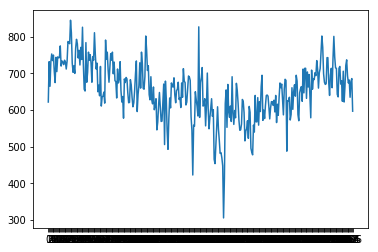

In [18]:
plt.plot(crimes_date.index,crimes_date.crimes_count)

## Calculating distances between Airbnb listings and criminal occurrences

We're interested in knowing the criminal activity surrounding each Airbnb listing. To do that, we'll calculate the distance between each unique location on our listings database and each unique location on our criminal occurrence database.

In [0]:
def distance(a,b):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees). Output in KM
    """
    lat1 = a[0]
    lat2 = b[0]
    lon1 = a[1]
    lon2 = b[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat / 2) ** 2 + cos(lat1) * cos(lat2) * sin(dlon / 2) ** 2
    c = 2 * asin(sqrt(a))
    km = 6371 * c
    return km

In [0]:
distances=[None]*len(list_locs)
for i in range(len(list_locs)):
  a=[None]*len(crim_locs)
  x=list_locs[i]
  for j in range(len(crim_locs)):
    a[j]=round(distance(x,crim_locs[j]),2)
  distances[i]=a
  
dist_df=pd.DataFrame(distances)

In [21]:
dist_df.head(10)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,27.71,4.15,17.39,3.73,3.34,6.00,5.55,2.22,42.94,6.94,42.99,46.14,41.98,23.29,16.13,18.84,3.44,49.74,49.54,24.61,46.97,36.57,48.54,3.44,4.00,45.88,41.97,0.00,9.21,5.92,5.82,4.99,0.83,6.65,8.38,7.56,6.74,5.92,5.11,1.11,...,43.42,42.14,40.26,39.61,42.34,47.15,44.80,44.36,43.93,41.28,44.89,42.63,42.44,43.49,44.70,43.70,38.89,43.33,40.64,46.83,44.48,44.09,26.00,45.69,3.50,5.46,49.92,6.74,47.23,19.35,45.05,16.40,4.75,43.98,4.71,5.11,663.84,45.59,45.71,44.88
1,26.42,3.50,16.12,2.37,2.00,4.71,4.16,1.39,41.55,5.55,41.61,44.76,40.64,21.98,15.12,17.59,2.78,48.35,48.16,23.23,45.59,35.18,47.15,2.22,2.73,44.50,40.61,1.39,8.31,5.46,5.11,4.30,1.11,5.92,7.48,6.65,5.82,4.98,4.15,0.83,...,42.03,40.76,38.91,38.27,40.97,45.76,43.41,42.98,42.55,39.93,43.51,41.28,41.11,42.17,43.33,42.34,37.62,41.97,39.31,45.46,43.11,42.72,24.61,44.33,2.49,4.30,48.53,6.23,45.86,18.10,43.67,15.32,4.16,42.63,3.34,4.71,664.30,44.21,44.32,43.49
2,24.59,6.23,8.33,8.38,7.48,5.11,7.01,9.97,36.21,6.70,35.89,38.33,37.15,14.39,5.92,9.41,10.85,42.03,42.14,17.66,39.27,29.44,41.35,9.20,6.64,37.86,36.53,10.21,1.39,5.33,4.71,5.46,9.40,4.00,2.00,2.73,3.50,4.30,5.11,10.03,...,36.93,36.11,35.10,34.83,36.73,39.98,38.27,37.97,37.69,36.19,38.74,37.44,38.03,39.14,39.09,38.02,35.59,37.81,35.93,40.85,38.48,38.24,18.99,40.17,6.74,4.98,42.72,4.71,41.11,17.66,37.46,6.22,11.84,38.70,6.74,6.00,660.19,37.89,38.91,37.62
3,22.62,8.70,5.55,10.03,9.40,6.74,8.30,11.84,33.52,7.55,33.16,35.56,34.72,11.62,4.30,6.68,12.51,39.26,39.39,15.04,36.50,26.73,38.61,10.85,8.60,35.09,34.01,12.45,4.16,8.04,7.32,8.00,11.68,6.68,4.71,5.33,6.00,6.70,7.43,12.10,...,34.27,33.51,32.63,32.42,34.18,37.25,35.60,35.32,35.05,33.73,36.11,34.95,35.67,36.78,36.53,35.45,33.45,35.27,33.52,38.24,35.88,35.65,16.34,37.62,8.95,7.01,39.98,7.47,38.48,16.27,34.70,4.15,13.29,36.19,8.38,8.66,661.15,35.12,36.21,34.89
4,22.48,8.00,6.08,9.20,8.60,5.92,7.47,11.02,33.84,6.73,33.52,36.01,34.83,12.17,5.11,7.32,11.68,39.71,39.79,15.29,36.94,27.08,38.99,10.03,7.80,35.57,34.18,11.68,3.73,7.47,6.68,7.32,10.91,6.09,4.16,4.71,5.33,6.00,6.70,11.30,...,34.56,33.74,32.76,32.51,34.37,37.62,35.90,35.60,35.32,33.86,36.37,35.10,35.74,36.84,36.73,35.65,33.40,35.45,33.61,38.48,36.11,35.88,16.61,37.81,8.19,6.22,40.36,6.94,38.74,15.91,35.12,4.98,12.46,36.35,7.56,8.04,661.60,35.56,36.54,35.27
5,22.24,5.55,8.69,5.92,5.46,2.73,4.15,7.80,35.27,3.50,35.12,37.94,35.45,14.63,8.38,10.16,8.38,41.60,41.55,16.67,38.83,28.65,40.65,6.74,4.71,37.59,35.05,8.70,3.73,5.80,4.75,5.10,8.00,4.52,3.44,3.34,3.44,3.73,4.16,8.19,...,35.88,34.86,33.51,33.10,35.32,39.26,37.25,36.89,36.54,34.58,37.56,35.88,36.19,37.29,37.69,36.64,33.40,36.37,34.18,39.61,37.24,36.93,18.04,38.74,5.33,3.34,42.03,5.62,39.93,14.83,36.95,8.30,9.13,37.18,4.30,6.09,663.41,37.44,38.01,36.94
6,22.30,4.75,10.16,4.30,4.00,1.39,2.49,6.22,36.08,2.00,36.01,38.98,35.88,15.98,10.03,11.67,6.74,42.61,42.49,17.55,39.84,29.55,41.55,5.11,3.34,38.67,35.60,7.32,4.71,5.56,4.45,4.52,6.68,4.52,4.16,3.73,3.44,3.34,3.44,6.70,...,36.64,35.53,34.00,33.51,35.90,40.16,38.01,37.62,37.25,35.05,38.24,36.37,36.53,37.62,38.27,37.24,33.52,36.93,34.58,40.26,37.89,37.56,18.94,39.30,4.16,2.37,42.93,5.62,40.61,14.55,37.94,9.96,7.47,37.69,2.73,5.62,664.32,38.45,38.83,37.86
7,21.39,8.66,5.32,9.40,8.95,6.22,7.55,11.30,32.82,6.64,32.53,35.09,33.73,11.38,5.46,6.70,11.84,38.78,38.83,14.24,36.01,26.08,38.01,10.21,8.18,34.67,33.10,12.14,4.75,8.33,7.47,8.04,11.41,6.94,5.10,5.55,6.08,6.68,7.32,11.68,...,33.52,32.68,31.67,31.41,33.29,36.64,34.86,34.56,34.27,32.76,35.32,34.01,34.63,35.74,35.65,34.58,32.29,34.37,32.51,37.42,35.05,34.81,15.58,36.73,8.70,6.70,39.38,7.86,37.69,14.90,34.18,5.10,12.50,35.27,7.80,8.85,662.54,34.63,35.53,34.29
8,20.29,9.42,4.71,9.72,9.42,6.70,7.80,11.68,31.80,6.73,

In [22]:
dist1_df=dist_df[dist_df<=1].notnull().astype('int')
dist1_df=dist1_df.fillna(0)
dist1_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [23]:
dist2_df=dist_df[dist_df<=2].notnull().astype('int')
dist2_df=dist2_df.fillna(0)
dist2_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [24]:
dist5_df=dist_df[dist_df<=5].notnull().astype('int')
dist5_df=dist5_df.fillna(0)
dist5_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,668,669,670,671,672,673,674,675,676,677,678,679,680,681,682,683,684,685,686,687,688,689,690,691,692,693,694,695,696,697,698,699,700,701,702,703,704,705,706,707
0,0,1,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0
1,0,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,1,1,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


#Creating our full Airbnb database

In [26]:
airbnb=calendar.merge(listings,on=['listing_id'],how='inner')
airbnb.head()

,listing_id,date,price,scr_date,month,day,year,time_since_scr,review,host_id,neighbourhood,latitude,longitude,room_type,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id,loc_id2
0,2384,2018-04-15,55.0,2018-04-15,4,15,2018,0 days,1,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
1,2384,2018-04-16,55.0,2018-04-15,4,16,2018,1 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
2,2384,2018-04-17,55.0,2018-04-15,4,17,2018,2 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
3,2384,2018-04-18,55.0,2018-04-15,4,18,2018,3 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71
4,2384,2018-04-22,55.0,2018-04-15,4,22,2018,7 days,1,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,71


In [97]:
airbnb_c=airbnb.merge(crimes_date,on=['date'])
airbnb_c['crimes_loc_1km']=np.nan
airbnb_c['crimes_loc_2km']=np.nan
airbnb_c['crimes_loc_5km']=np.nan
airbnb_c['crimes_1km']=np.nan
airbnb_c['crimes_2km']=np.nan
airbnb_c['crimes_5km']=np.nan
airbnb_c['loc_id'] = airbnb_c.loc_id2
airbnb_c['crim_loc_id'] = airbnb_c.crim_loc_id2
airbnb_c = airbnb_c.drop(columns=['loc_id2','crim_loc_id2'])
airbnb_c = airbnb_c.assign(date_id=(airbnb_c['date'].astype('category').cat.codes))
airbnb_c = airbnb_c.sort_values(by=['listing_id','date'])
airbnb_c.head()

,listing_id,date,price,scr_date,month,day,year,time_since_scr,review,host_id,neighbourhood,latitude,longitude,room_type,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id_x,loc_id_y,crimes_count_date,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,loc_id,crim_loc_id,date_id
0,2384,2018-07-09,60.0,2018-04-15,7,9,2018,85 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6280, 603...",622,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 414, 173, ...",0
2880,2384,2018-07-10,60.0,2018-04-15,7,10,2018,86 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 6039, 6105, 6105, 610...",732,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 173, 239, 239, 239, 2...",1
5759,2384,2018-07-11,60.0,2018-04-15,7,11,2018,87 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6039, 6105, ...",665,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 173, 239, 239...",2
8480,2384,2018-07-12,60.0,2018-04-15,7,12,2018,88 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6039, ...",732,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 173, 23...",3
11105,2384,2018-07-13,60.0,2018-04-15,7,13,2018,89 days,0,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",753,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",4


In [98]:
airbnb_cr=airbnb_c[airbnb_c.review==1]
airbnb_cr=airbnb_cr.drop(columns=['review'])
airbnb_cr

,listing_id,date,price,scr_date,month,day,year,time_since_scr,host_id,neighbourhood,latitude,longitude,room_type,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365,lr_m,lr_d,lr_y,lat,lon,location,loc,loc_id_x,loc_id_y,crimes_count_date,crimes_loc_1km,crimes_loc_2km,crimes_loc_5km,crimes_1km,crimes_2km,crimes_5km,loc_id,crim_loc_id,date_id
38834,2384,2018-07-26,75.0,2018-07-18,7,26,2018,8 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 610...",731,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 239...",17
47199,2384,2018-07-29,69.0,2018-07-18,7,29,2018,11 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",731,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",20
64461,2384,2018-08-05,65.0,2018-04-15,8,5,2018,112 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",811,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27
85514,2384,2018-08-12,75.0,2018-07-18,8,12,2018,25 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 6039, 6105, 6105, 627...",781,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 173, 239, 239, 408, 4...",34
177947,2384,2018-10-01,65.0,2018-05-18,10,1,2018,136 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6280, ...",732,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 414, 17...",84
291761,2384,2018-10-31,75.0,2018-07-18,10,31,2018,105 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 6039, 6274, 6274, 627...",802,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 173, 408, 408, 408, 4...",114
312731,2384,2018-11-05,65.0,2018-10-11,11,5,2018,25 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 6280, 6280, 6280, 610...",628,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 414, 414, 414, 239, 2...",119
329861,2384,2018-11-09,65.0,2018-10-11,11,9,2018,29 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6280, 6280, 628...",663,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 414, 414, 414, ...",123
342432,2384,2018-11-12,65.0,2018-10-11,11,12,2018,32 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 6280, 6039, 6105, 6105, 6105, ...",631,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 414, 173, 239, 239, 239, 408, ...",126
420660,2384,2018-11-30,65.0,2018-10-11,11,30,2018,50 days,2613,Hyde Park,41.78886,-87.58671,2,159,2019-07-11,2.89,1,306,7,11,2019,41.79,-87.59,"(41.78886, -87.58671)","(41.79, -87.59)",124,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 6039, 6039, ...",674,NaN,NaN,NaN,NaN,NaN,NaN,71,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 173, 173, 40...",144


Groubpy loc_id, listing_id, date 

In [0]:
def indices(lst, element):
    result = []
    offset = -1
    while True:
        try:
            offset = lst.index(element, offset+1)
        except ValueError:
            return result
        result.append(offset)

In [0]:
#for i in range(len(airbnb_cr)):
#  crimes_that_day=list(airbnb_cr.crim_loc_id.iloc[i])
#  loc_id=airbnb_cr.loc_id.iloc[i]
#  crimes_loc_1km=list(indices(list(dist1_df.iloc[loc_id]),1))
  #crimes_loc_2km=list(np.setdiff1d(indices(list(dist2_df.loc[loc_id]),1),indices(list(dist1_df.loc[loc_id]),1)))
  #crimes_loc_5km=list(np.setdiff1d(indices(list(dist5_df.loc[loc_id]),1),indices(list(dist2_df.loc[loc_id]),1)))
#  airbnb_cr.crimes_1km.iloc[i] = set(crimes_loc_1km).intersection(crimes_that_day)
  #airbnb_cr.crimes_2km.iloc[i] = set(crimes_loc_2km).intersection(crimes_that_day)
  #airbnb_cr.crimes_5km.iloc[i] = set(crimes_loc_5km).intersection(crimes_that_day)

In [99]:
for i in range(len(airbnb_cr)):
  loc_id=airbnb_cr.loc_id.iloc[i]
  crimes_loc_1km=list(indices(list(dist1_df.iloc[loc_id]),1))
  crimes_loc_2km=list(np.setdiff1d(indices(list(dist2_df.loc[loc_id]),1),indices(list(dist1_df.loc[loc_id]),1)))
  crimes_loc_5km=list(np.setdiff1d(indices(list(dist5_df.loc[loc_id]),1),indices(list(dist2_df.loc[loc_id]),1)))

KeyboardInterrupt: ignored